In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os

In [15]:
original_data_dir = r"D:\MED_LEAF_ID\data\cnn\original"
augmented_data_dir =  r"D:\MED_LEAF_ID\data\cnn\augmented"


In [16]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet mean & std
])


In [17]:
val_test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [18]:
# Loading datasets
train_data = datasets.ImageFolder(root=original_data_dir, transform=train_transforms)
augmented_data = datasets.ImageFolder(root=augmented_data_dir, transform=train_transforms)

# Merging datasets
full_train_data = torch.utils.data.ConcatDataset([train_data, augmented_data])

# Split dataset into train, validation, and test sets
train_size = int(0.7 * len(full_train_data))
val_size = int(0.15 * len(full_train_data))
test_size = len(full_train_data) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(full_train_data, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [19]:
class EfficientNetB0Classifier(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNetB0Classifier, self).__init__()
        self.base_model = torchvision.models.efficientnet_b0(pretrained=True)
        self.base_model.classifier[1] = nn.Linear(self.base_model.classifier[1].in_features, num_classes)
        self.base_model.classifier.add_module('dropout', nn.Dropout(0.2))  # Added dropout

    def forward(self, x):
        return self.base_model(x)

In [20]:
num_classes = len(train_data.classes)
model = EfficientNetB0Classifier(num_classes=num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(device)
criterion = nn.CrossEntropyLoss()

y_train = [label for _, label in train_dataset]
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

d:\MED_LEAF_ID\base\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\MED_LEAF_ID\base\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


cuda


In [23]:
def train(model, train_loader, val_loader, optimizer, criterion, num_epochs=30, patience=5):
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_wts = model.state_dict()
    
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0

        for inputs, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_preds += torch.sum(preds == labels.data)
            total_preds += labels.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct_preds.double() / total_preds

        model.eval()
        val_loss = 0.0
        correct_preds = 0
        total_preds = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct_preds += torch.sum(preds == labels.data)
                total_preds += labels.size(0)

        val_loss /= len(val_loader.dataset)
        val_acc = correct_preds.double() / total_preds

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print("Early stopping triggered")
            break

        train_losses.append(epoch_loss)
        val_losses.append(val_loss)
        train_accuracies.append(epoch_acc)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} => Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses, train_accuracies, val_accuracies


In [24]:
for inputs, labels in train_loader:
    print("Labels in batch:", labels[:10].cpu().numpy())  # Check if labels are within range
    break


Labels in batch: [67 14 58 35 71 31  0 53 21 55]


In [25]:
model, train_losses, val_losses, train_accuracies, val_accuracies = train(
    model, train_loader, val_loader, optimizer, criterion, num_epochs=30, patience=5
)


Training Epoch 1/30:   0%|          | 0/302 [00:00<?, ?it/s]

Training Epoch 1/30: 100%|██████████| 302/302 [03:25<00:00,  1.47it/s]


Epoch 1/30 => Train Loss: 3.2919, Train Accuracy: 0.2393, Val Loss: 2.0551, Val Accuracy: 0.4560


Training Epoch 2/30: 100%|██████████| 302/302 [05:11<00:00,  1.03s/it]


Epoch 2/30 => Train Loss: 2.2496, Train Accuracy: 0.4512, Val Loss: 1.3951, Val Accuracy: 0.6266


Training Epoch 3/30: 100%|██████████| 302/302 [06:20<00:00,  1.26s/it]


Epoch 3/30 => Train Loss: 1.8884, Train Accuracy: 0.5346, Val Loss: 1.2726, Val Accuracy: 0.6531


Training Epoch 4/30: 100%|██████████| 302/302 [03:42<00:00,  1.36it/s]


Epoch 4/30 => Train Loss: 1.6834, Train Accuracy: 0.5817, Val Loss: 1.0287, Val Accuracy: 0.7198


Training Epoch 5/30: 100%|██████████| 302/302 [03:23<00:00,  1.48it/s]


Epoch 5/30 => Train Loss: 1.5821, Train Accuracy: 0.5993, Val Loss: 0.9065, Val Accuracy: 0.7449


Training Epoch 6/30: 100%|██████████| 302/302 [03:19<00:00,  1.52it/s]


Epoch 6/30 => Train Loss: 1.4874, Train Accuracy: 0.6258, Val Loss: 0.7908, Val Accuracy: 0.7720


Training Epoch 7/30: 100%|██████████| 302/302 [03:34<00:00,  1.41it/s]


Epoch 7/30 => Train Loss: 1.4097, Train Accuracy: 0.6438, Val Loss: 0.8112, Val Accuracy: 0.7729


Training Epoch 8/30: 100%|██████████| 302/302 [03:02<00:00,  1.66it/s]


Epoch 8/30 => Train Loss: 1.3904, Train Accuracy: 0.6430, Val Loss: 0.7445, Val Accuracy: 0.7976


Training Epoch 9/30: 100%|██████████| 302/302 [02:41<00:00,  1.87it/s]


Epoch 9/30 => Train Loss: 1.3031, Train Accuracy: 0.6653, Val Loss: 0.7197, Val Accuracy: 0.8019


Training Epoch 10/30: 100%|██████████| 302/302 [03:01<00:00,  1.67it/s]


Epoch 10/30 => Train Loss: 1.2828, Train Accuracy: 0.6697, Val Loss: 0.6532, Val Accuracy: 0.8193


Training Epoch 11/30: 100%|██████████| 302/302 [02:42<00:00,  1.86it/s]


Epoch 11/30 => Train Loss: 1.2569, Train Accuracy: 0.6738, Val Loss: 0.6519, Val Accuracy: 0.8121


Training Epoch 12/30: 100%|██████████| 302/302 [02:55<00:00,  1.73it/s]


Epoch 12/30 => Train Loss: 1.2186, Train Accuracy: 0.6860, Val Loss: 0.5921, Val Accuracy: 0.8285


Training Epoch 13/30: 100%|██████████| 302/302 [02:27<00:00,  2.05it/s]


Epoch 13/30 => Train Loss: 1.2281, Train Accuracy: 0.6855, Val Loss: 0.6351, Val Accuracy: 0.8300


Training Epoch 14/30: 100%|██████████| 302/302 [02:15<00:00,  2.24it/s]


Epoch 14/30 => Train Loss: 1.2193, Train Accuracy: 0.6826, Val Loss: 0.5897, Val Accuracy: 0.8415


Training Epoch 15/30: 100%|██████████| 302/302 [02:11<00:00,  2.30it/s]


Epoch 15/30 => Train Loss: 1.1746, Train Accuracy: 0.6934, Val Loss: 0.6272, Val Accuracy: 0.8256


Training Epoch 16/30: 100%|██████████| 302/302 [03:00<00:00,  1.67it/s]


Epoch 16/30 => Train Loss: 1.1404, Train Accuracy: 0.7012, Val Loss: 0.5394, Val Accuracy: 0.8541


Training Epoch 17/30: 100%|██████████| 302/302 [03:17<00:00,  1.53it/s]


Epoch 17/30 => Train Loss: 1.1482, Train Accuracy: 0.6984, Val Loss: 0.5321, Val Accuracy: 0.8498


Training Epoch 18/30: 100%|██████████| 302/302 [03:11<00:00,  1.58it/s]


Epoch 18/30 => Train Loss: 1.1137, Train Accuracy: 0.7040, Val Loss: 0.5189, Val Accuracy: 0.8556


Training Epoch 19/30: 100%|██████████| 302/302 [03:11<00:00,  1.58it/s]


Epoch 19/30 => Train Loss: 1.1392, Train Accuracy: 0.7009, Val Loss: 0.5489, Val Accuracy: 0.8449


Training Epoch 20/30: 100%|██████████| 302/302 [03:19<00:00,  1.52it/s]


Epoch 20/30 => Train Loss: 1.0994, Train Accuracy: 0.7119, Val Loss: 0.5392, Val Accuracy: 0.8556


Training Epoch 21/30: 100%|██████████| 302/302 [03:19<00:00,  1.52it/s]


Epoch 21/30 => Train Loss: 1.0952, Train Accuracy: 0.7133, Val Loss: 0.5433, Val Accuracy: 0.8517


Training Epoch 22/30: 100%|██████████| 302/302 [03:13<00:00,  1.56it/s]


Epoch 22/30 => Train Loss: 1.1274, Train Accuracy: 0.6995, Val Loss: 0.5252, Val Accuracy: 0.8541


Training Epoch 23/30: 100%|██████████| 302/302 [03:19<00:00,  1.51it/s]


Early stopping triggered


Test Accuracy: 0.8691


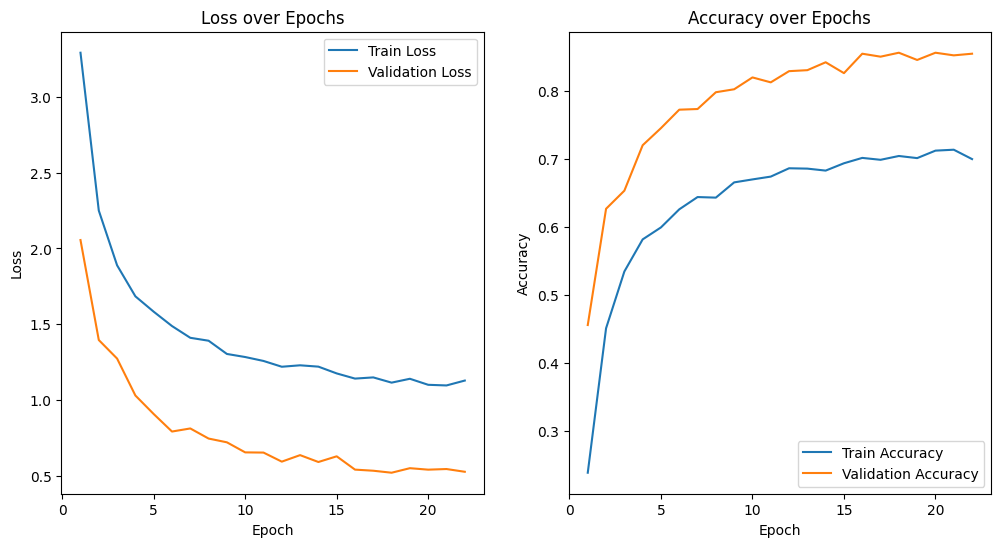

In [30]:
import torch
import matplotlib.pyplot as plt

# Ensure the model is in evaluation mode
model.eval()

correct_preds = 0
total_preds = 0

# Disable gradient calculation for testing
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        correct_preds += torch.sum(preds == labels.data)
        total_preds += labels.size(0)

# Convert test accuracy to float for better readability
test_accuracy = correct_preds.double().cpu().item() / total_preds
print(f"Test Accuracy: {test_accuracy:.4f}")

# Save model weights
torch.save(model.state_dict(), "efficientnetb0_leaf_model.pth")

# Convert PyTorch tensors/lists to NumPy
def to_numpy(tensor):
    if isinstance(tensor, torch.Tensor):
        return tensor.detach().cpu().numpy()  # Moves to CPU and converts to NumPy
    return tensor  # If it's already a NumPy array or list, return as is

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 6))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, to_numpy(torch.tensor(train_losses)), label='Train Loss')
plt.plot(epochs, to_numpy(torch.tensor(val_losses)), label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, to_numpy(torch.tensor(train_accuracies)), label='Train Accuracy')
plt.plot(epochs, to_numpy(torch.tensor(val_accuracies)), label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [31]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Ensure model is in evaluation mode
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        # Store predictions & true labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to NumPy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)


In [32]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Overall Accuracy
accuracy = accuracy_score(all_labels, all_preds)

# Precision, Recall, F1-score (macro and weighted)
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Full Classification Report
print("\nClassification Report:\n", classification_report(all_labels, all_preds))


Accuracy: 0.8565
Precision: 0.8688
Recall: 0.8567
F1-score: 0.8562

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.97      0.91        31
           1       0.77      0.95      0.85        21
           2       0.69      0.88      0.77        25
           3       0.93      0.96      0.95        27
           4       0.57      0.74      0.64        23
           5       0.83      0.62      0.71        24
           6       1.00      0.94      0.97        17
           7       0.93      0.82      0.88        34
           8       0.95      0.95      0.95        38
           9       0.83      0.97      0.90        36
          10       0.89      0.76      0.82        33
          11       0.67      0.80      0.73        20
          12       1.00      0.71      0.83        21
          13       0.95      0.90      0.93        41
          14       0.65      0.94      0.77        36
          15       0.81      0.89      0.85